<a href="https://colab.research.google.com/github/WCosmo/DL_Final_Project/blob/main/DL_final_project_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
DL - Final Project
Project Name: LSTM Chatbot
Student: Wilson Cosmo
Date: 06/12/2022

'''

In [ ]:
if 'google.colab' in str(get_ipython()):
    import sys
    import os
    try:
      !git clone https://github.com/WCosmo/DL_Final_Project.git
    except:
      print("DL_Final_Project is already in the contents")    

In [167]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt
import numpy as np
import random
import re
import os

In [168]:
!cd DL_Final_Project/base_dataset/

In [169]:
data_i = 'data_input.chat'
data_o = 'data_output.chat'

In [170]:
n_pair = 276 #number of pairs
start_point = 10 #modify to skip some lines
f1 = open(data_i, 'r')
f2 = open(data_o, 'r')

In [171]:
def data_clean(n_line):  
  char_out = {46: None, 44: None, 10: None} # . , /n
  buffer = n_line.translate(char_out)
  return buffer

In [198]:
l1 = []
l2 = []
i = 0

for i in range(n_pair):

  s_buff = f1.readline(i+start_point)   
  if data_clean(s_buff) != '':
    l1.append(data_clean(s_buff))   

  s_buff = f2.readline(i+start_point)
  if data_clean(s_buff) != '':
    l2.append(data_clean(s_buff))  


In [173]:
pairs = list(zip(l1,l2))

In [ ]:
pairs[25:35] #debug

In [175]:
input_docs = []
target_docs = []
input_tokens = set()
target_tokens = set()

In [176]:
for line in pairs[:n_pair]:
  input_doc, target_doc = line[0], line[1]
  # Appending each input sentence to input_docs
  input_docs.append(input_doc)
  # Splitting words from punctuation  
  target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
  # Redefine target_doc below and append it to target_docs
  target_doc = '<START> ' + target_doc + ' <END>'
  target_docs.append(target_doc)
  
  # Now we split up each sentence into words and add each unique word to our vocabulary set
  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)
  for token in target_doc.split():
    if token not in target_tokens:
      target_tokens.add(token)

input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

In [ ]:
input_tokens #debug

In [177]:
input_features_dict = dict(
    [(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict(
    [(token, i) for i, token in enumerate(target_tokens)])
reverse_input_features_dict = dict(
    (i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict(
    (i, token) for token, i in target_features_dict.items())

In [178]:
#Maximum length of sentences in input and target documents
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])
encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        #Assign 1. for the current line, timestep, & word in encoder_input_data
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.
    
    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.

In [ ]:
encoder_input_data.shape #debug

In [180]:
#Dimensionality
dimensionality = 256

#The batch size and number of epochs
batch_size = 16
epochs = 250

opt=keras.optimizers.RMSprop(learning_rate=1e-3) #optimizer

#Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True, dropout=0.2)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

#Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
#Model
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

#Compiling
training_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["AUC"], sample_weight_mode='temporal')

#Training
fit_info = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.2)


In [197]:
model_name = "chat_model_epochs_" + str(epochs) + ".h5"
training_model.save(model_name)

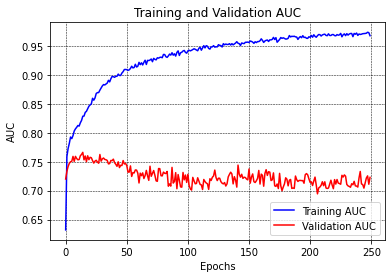

In [196]:
history_dict = fit_info.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
auc_values = history_dict['auc'] 
val_auc_values = history_dict['val_auc'] 

plt.plot(np.arange(epochs), auc_values, color = 'b', label='Training AUC') 
plt.plot(np.arange(epochs), val_auc_values, color = 'r', label='Validation AUC') 
plt.title('Training and Validation AUC')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.show()

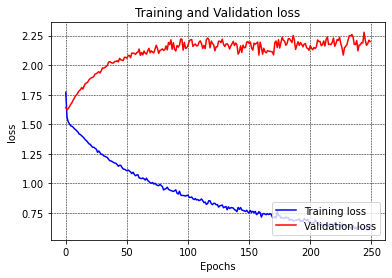

In [195]:
plt.plot(np.arange(epochs), loss_values, color = 'b', label='Training loss') 
plt.plot(np.arange(epochs), val_loss_values, color = 'r', label='Validation loss') 
plt.title('Training and Validation loss')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.5)
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(loc='lower right')
plt.show()

In [186]:
training_model = load_model(model_name)
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

In [187]:
latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]

In [188]:
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

In [189]:
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [190]:
def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.
    
    #A variable to store our response word by word
    decoded_sentence = ''
    
    stop_condition = False
    while not stop_condition:
          #Predicting output tokens with probabilities and states
          output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
    #Choosing the one with highest probability
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_token = reverse_target_features_dict[sampled_token_index]
          decoded_sentence += " " + sampled_token
    #Stop if hit max length or found the stop token
          if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
    #Update the target sequence
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, sampled_token_index] = 1.
          #Update states
          states_value = [hidden_state, cell_state]
    return decoded_sentence

In [194]:
class ChatBot:
  negative_responses = ("não", "nao")
  exit_commands = ("fechar", "sair", "adeus", "tchau", "até mais", "pare")

  def start_chat(self): #Method to start the conversation
    user_response = input("Olá, sou um chatbot gerado para a disciplina de Deep Learning.\nConverse comigo e eu farei o meu melhor para gerar uma resposta.\nVocê > ")
    
    if user_response in self.negative_responses:
      print("Ok, até mais!")
      return
    self.chat(user_response)

  def chat(self, reply): #Method to handle the conversation
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"")    
  
  def string_to_matrix(self, user_input): #Method to convert user input into a matrix
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix  
  
  def generate_response(self, user_input): #Method that will create a response using seq2seq model we built
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    chatbot_response = 'Bot > ' + chatbot_response + '\nVocê > '
    return chatbot_response

  def make_exit(self, reply): #Method to check for exit commands
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Bot > Ok, até mais tarde...")
        return True
    return False
  
chatbot = ChatBot()

In [ ]:
chatbot.start_chat()